<a href="https://colab.research.google.com/github/sdobnik/apl-esslli-19/blob/master/exercises/1-learn_to_compose_with_lm/encoder-decoder_image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Description with Encoder-Decoder 

In this tutorial, you get familar with using pretrained convolutional neural networks (ConvNets) for caption generation.

In [0]:
%matplotlib inline

In [0]:
## library
# GPU selection (if needed)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from matplotlib import pyplot as plt

from glob import glob

## Encode images with a pre-trained ConvNets

In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Pre-trained models are originally trained on Imagenet for object recognition task.
# By expluding the top-layer, which contains 1000 classes, we use it as image embeddings:
convnet_model = ResNet50(weights='imagenet', input_shape=[224, 224, 3],  include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


The model's output shape: (None, 7, 7, 2048)


In [36]:
# For each image, the output is a matrix of 7 x 7 regions,
# which each region is represented with a 2048-dimension vector.
print("The model's output shape:", convnet_model.output_shape)

The model's output shape: (None, 7, 7, 2048)


In [0]:
# download few sample images
! mkdir sample_images
! wget -P sample_images/ https://gubox.box.com/shared/static/ois9pg8t2j65ir8lhcapo7e3yctzwj27.jpg 
! wget -P sample_images/ https://gubox.box.com/shared/static/7yo0mhiz8wi81ysfbgjns6f2cgsc80yk.jpg 
! wget -P sample_images/ https://gubox.box.com/shared/static/8yzk194f3flmctzqe344fq39deyhanl6.jpg 
! wget -P sample_images/ https://gubox.box.com/shared/static/vpg4gc5k1xocp0r9y5tyfjqtphr7ntj2.jpg 
! wget -P sample_images/ https://gubox.box.com/shared/static/r6l4zoaxs37e8dvqz12wb8omeo2h604e.jpg 

In [0]:
img_paths = [
    path
    for path in glob('sample_images/*.jpg')
]
imgs = np.array([
    image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    for img_path in img_paths
])
x = preprocess_input(imgs)

In [0]:
visual_features = convnet_model.predict(x)
visual_features = visual_features.reshape([visual_features.shape[0],49,2048])

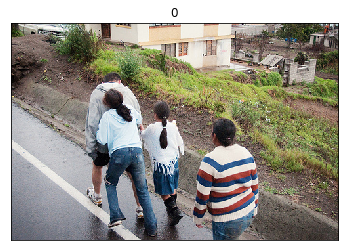

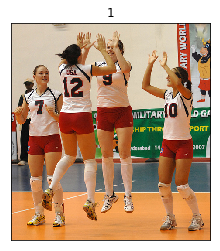

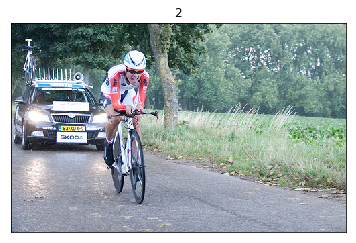

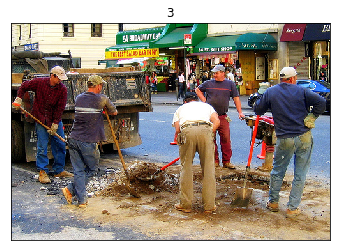

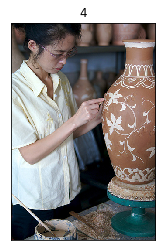

In [23]:
for i, img_path in enumerate(img_paths):
    plt.imshow(plt.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
    plt.show()

## Decode conditional language model

We trained a simple condigional language model on Flickr30K corpus, conditioned with visual features from pre-trained ResNet50 model. 

```
@article{flickrentitiesijcv,
         author={Bryan A. Plummer and Liwei Wang and Christopher M. Cervantes and Juan C. Caicedo and Julia Hockenmaier and Svetlana Lazebnik},
         title={Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models},
         journal={IJCV},
         volume={123},
         number={1},
         pages={74-93},
         year={2017} 
}```

In [0]:
# download the caption model
! wget https://gubox.box.com/shared/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
! mv 3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5 simple_caption_model.h5

In [0]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

caption_model = load_model("simple_caption_model.h5")

In [0]:
# download coding info about the decoder
! mkdir preprocessed_flickr30k
! wget https://gubox.box.com/shared/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
! mv 7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy preprocessed_flickr30k/ix2word.npy

In [0]:
max_len = 25
ix2word = np.load('preprocessed_flickr30k/ix2word.npy', allow_pickle=True)[None][0]
word2ix = {w: ix for ix, w in ix2word.items()}

def sent2ixs(sent):
    return [word2ix['<s>']]+[word2ix[w] for w in sent]+[word2ix['</s>']]+[word2ix['<pad/>']]*(max_len-len(sent))

def ixs2sent(ixs):
    return [ix2word[ix] for ix in ixs if ix2word[ix] != '<pad/>']

## Evaluation

#### Comparing the likelihood of sentences

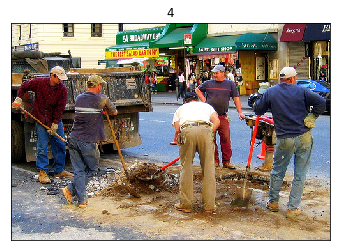

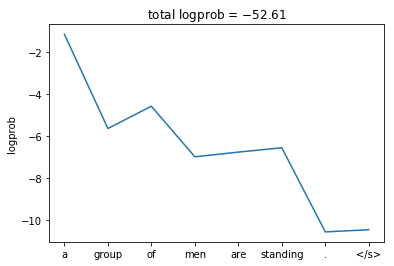

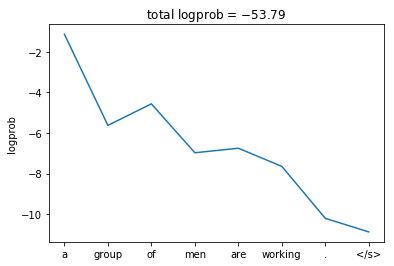

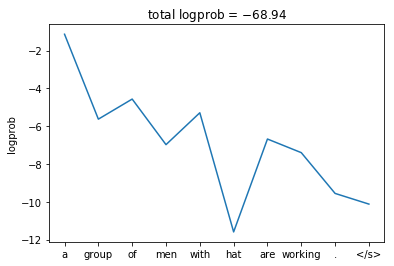

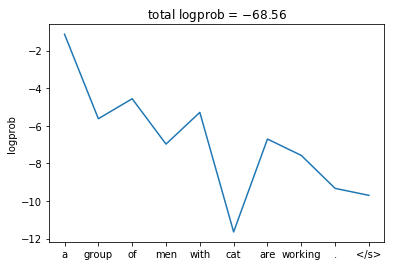

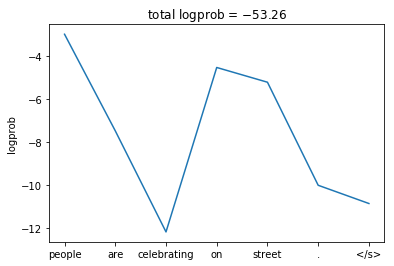

In [32]:
image_index = 3

plt.imshow(plt.imread(img_paths[image_index]))
plt.xticks([])
plt.yticks([])
plt.title(i)
plt.show()

# compare sentences
sents = np.array([
    sent2ixs("a group of men are standing .".split(" ")),
    sent2ixs("a group of men are working .".split(" ")),
    sent2ixs("a group of men with hat are working .".split(" ")),
    sent2ixs("a group of men with cat are working .".split(" ")),
    sent2ixs("people are celebrating on street .".split(" ")),
])

# repeat the same image for all test sentences:
vfs = np.array([visual_features[image_index]] * len(sents))

# predict the token probabilities with the given sentnece and the visual features:
sents_prs = caption_model.predict([sents[:, :-1], vfs])
for sent, prs in zip(sents[:, 1:], sents_prs):
    words_prs = [
        (ix2word[ixw], pr[ixw])
        for pr, ixw in zip(prs, sent)
        if ix2word[ixw] not in {'<pad/>'}
    ]
    
    words, prs = zip(*words_prs)
    
    logprobs = np.log(prs)
    plt.title("total logprob = ${0:.2f}$".format(logprobs.sum()))
    plt.plot(logprobs)
    plt.xticks(range(len(words)), words)
    plt.ylabel("logprob")
    plt.show()
    

#### Beam Search for caption generation

In [0]:
# This implementation only accepts one source image as source input.
def search(model, src_input, k=1, sequence_max_len=25):
    # (log(1), initialize_of_zeros)
    k_beam = [(0, [word2ix['<s>'],word2ix['</s>']]+[word2ix['<pad/>']]*(sequence_max_len-1))]

    # l : point on target sentence to predict
    for l in range(sequence_max_len):
        all_k_beams = []
        for prob, sent_predict in k_beam:
            predicted = model.predict([np.array([sent_predict]), np.array([src_input])])[0]
            # top k!
            possible_k = predicted[l].argsort()[-k:][::-1]

            # add to all possible candidates for k-beams
            all_k_beams += [
                (
                    sum(np.log(predicted[i][sent_predict[i+1]]) for i in range(l)) + np.log(predicted[l][next_wid]),
                    list(sent_predict[:l+1])+[next_wid]+[0]*(sequence_max_len-l-1)
                )
                for next_wid in possible_k
            ]

        # top k
        k_beam = sorted(all_k_beams)[-k:][::-1]

    return k_beam

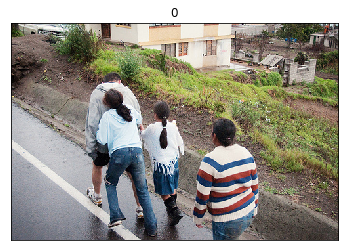

Top 5 beams:
logprob=-25.41 sent=a man is a man is a man is a man is a man is a man is a man is a man is
logprob=-26.45 sent=a man is a dog is a man is a man is a man is a man is a man is a man is
logprob=-26.50 sent=a man is a man is a man is a man is a man is a man is a man is a dog is
logprob=-26.79 sent=a man is a man is a man is a man is a man is a man is a man is a man is
logprob=-26.79 sent=a man is a a man is a man is a man is a man is a man is a man is a man


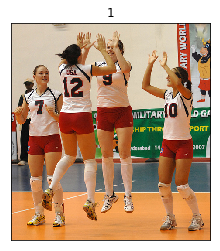

Top 5 beams:
logprob=-41.75 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball
logprob=-42.00 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two
logprob=-42.11 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two
logprob=-42.18 sent=a basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two
logprob=-42.27 sent=a basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two


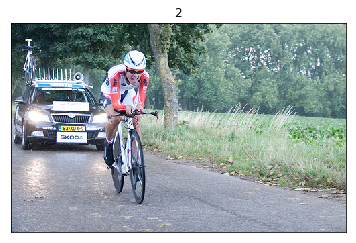

Top 5 beams:
logprob=-16.95 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.09 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.71 sent=a a a a a a a a a a a a a a a a a a a a a a man is
logprob=-18.91 sent=a man is a a a a a a a a a a a a a a a a a a a a a
logprob=-18.94 sent=a man a a a a a a a a a a a a a a a a a a a a a a


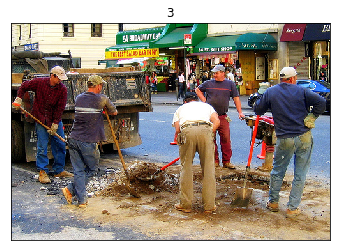

Top 5 beams:
logprob=-37.15 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.35 sent=a three a children a front a front a front a front a front a front a front a front a front front front
logprob=-37.54 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.58 sent=a three a children a front a front a front a front a front a front a front a front a front front a
logprob=-37.61 sent=a three a children a front a front a front a front a front a front a front a front a front front front


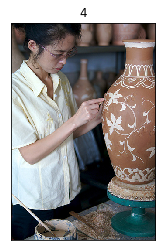

Top 5 beams:
logprob=-26.46 sent=a woman sitting in a woman in a woman in a woman in a woman in a woman in a woman in a woman
logprob=-26.50 sent=a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.21 sent=a woman in a woman in a girl in a woman in a woman in a woman in a woman in a woman in
logprob=-27.23 sent=a woman in a girl in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.31 sent=a woman in a woman in a woman in a girl in a woman in a woman in a woman in a woman in


In [34]:
k = 5
for i, vf in enumerate(visual_features):
    plt.imshow(plt.imread(img_paths[i]))
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
    plt.show()
    print("Top {0} beams:".format(k))
    top_k = search(caption_model, vf, k=k)
    for logprob, ixs in top_k:
        print("logprob={0:.2f} sent={1}".format(logprob, " ".join(ixs2sent(ixs)[1:-1])))